In [26]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [27]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [28]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [29]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [30]:
tf.keras.backend.clear_session()

In [31]:
subject = 'Distrito Federal - Consumo de Cimento (t)'
start_index = 0
split_index = 179
window_size = 36
train_split = split_index + 1 - 12

In [32]:
data = pd.read_csv('2003_mo_model_input_DF.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Distrito Federal - value,Distrito Federal - Desemprego,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Distrito Federal - IDH,Distrito Federal - Consumo de Cimento (t),Distrito Federal - PIB - Estadual,Distrito Federal - PIB - Construção Civil,Distrito Federal - PIB - Per Capita,Distrito Federal - PIB - Preços de Mercado,Distrito Federal - Produção de Cimento (t)
0,2003-1,0.254227,8.293882,0.724032,-5331.049150,11.520143,1.639718,1.036534,1.772069e+08,7.330309e+06,0.969649,0.826971,50.047,1.184017e+08,3.570616e+06,43.639430,1.092465e+08,156.625720
1,2003-2,0.252655,8.287887,0.690297,-5318.079644,11.189862,1.378899,0.993449,1.773884e+08,7.335910e+06,0.950783,0.827063,48.110,1.185511e+08,3.573184e+06,43.651300,1.093025e+08,157.678528
2,2003-3,0.250972,8.281892,0.669681,-5436.417870,10.820792,1.924317,0.973020,1.775699e+08,7.341511e+06,0.938332,0.827155,49.006,1.187006e+08,3.575752e+06,43.663170,1.093585e+08,159.190268
3,2003-4,0.249179,8.275896,0.660494,-5707.015274,10.417840,1.331174,0.940489,1.777514e+08,7.347112e+06,0.926401,0.827247,48.445,1.188500e+08,3.578320e+06,43.675041,1.094145e+08,160.688376
4,2003-5,0.247070,8.269901,0.648337,-5599.317941,9.959690,1.736072,0.917493,1.779329e+08,7.352713e+06,0.951683,0.827340,51.436,1.189994e+08,3.580889e+06,43.686911,1.094705e+08,162.847410
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2022-8,0.529279,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77.448,NaN,NaN,NaN,NaN,250.077918
236,2022-9,0.527896,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.321,NaN,NaN,NaN,NaN,248.545664
237,2022-10,0.526069,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72.839,NaN,NaN,NaN,NaN,248.265413
238,2022-11,0.523943,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.598,NaN,NaN,NaN,NaN,247.486640


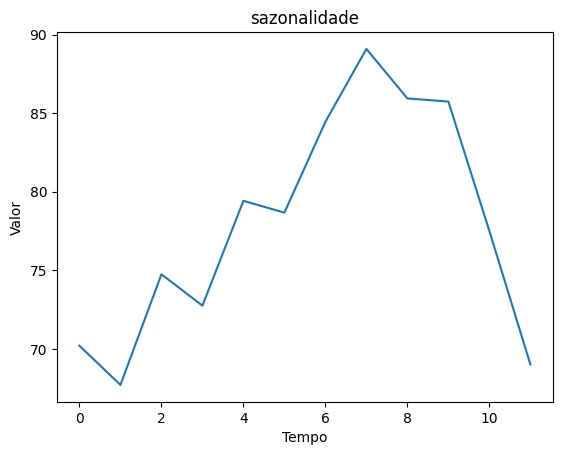

,sazonalidade
sazonalidade,
0,70.194429
1,67.700143
2,74.741036
3,72.748071
4,79.418643
5,78.665500
6,84.447714
7,89.086714
8,85.934714


In [33]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [34]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Distrito Federal - value,Distrito Federal - Desemprego,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Distrito Federal - IDH,Distrito Federal - PIB - Estadual,Distrito Federal - PIB - Construção Civil,Distrito Federal - PIB - Per Capita,Distrito Federal - PIB - Preços de Mercado,Distrito Federal - Produção de Cimento (t),sazonalidade,Distrito Federal - Consumo de Cimento (t)
0,2003-1,0.254227,8.293882,0.724032,-5331.049150,11.520143,1.639718,1.036534,1.772069e+08,7.330309e+06,0.969649,0.826971,1.184017e+08,3.570616e+06,43.639430,1.092465e+08,156.625720,70.194429,50.047
1,2003-2,0.252655,8.287887,0.690297,-5318.079644,11.189862,1.378899,0.993449,1.773884e+08,7.335910e+06,0.950783,0.827063,1.185511e+08,3.573184e+06,43.651300,1.093025e+08,157.678528,67.700143,48.110
2,2003-3,0.250972,8.281892,0.669681,-5436.417870,10.820792,1.924317,0.973020,1.775699e+08,7.341511e+06,0.938332,0.827155,1.187006e+08,3.575752e+06,43.663170,1.093585e+08,159.190268,74.741036,49.006
3,2003-4,0.249179,8.275896,0.660494,-5707.015274,10.417840,1.331174,0.940489,1.777514e+08,7.347112e+06,0.926401,0.827247,1.188500e+08,3.578320e+06,43.675041,1.094145e+08,160.688376,72.748071,48.445
4,2003-5,0.247070,8.269901,0.648337,-5599.317941,9.959690,1.736072,0.917493,1.779329e+08,7.352713e+06,0.951683,0.827340,1.189994e+08,3.580889e+06,43.686911,1.094705e+08,162.847410,79.418643,51.436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2022-8,0.529279,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,250.077918,89.086714,77.448
236,2022-9,0.527896,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,248.545664,85.934714,64.321
237,2022-10,0.526069,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,248.265413,85.735214,72.839
238,2022-11,0.523943,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,247.486640,77.502429,59.598


In [35]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      62.294
1      55.247
2      65.908
3      67.387
4      68.730
        ...  
235       NaN
236       NaN
237       NaN
238       NaN
239       NaN
Name: Distrito Federal - Consumo de Cimento (t), Length: 240, dtype: float64

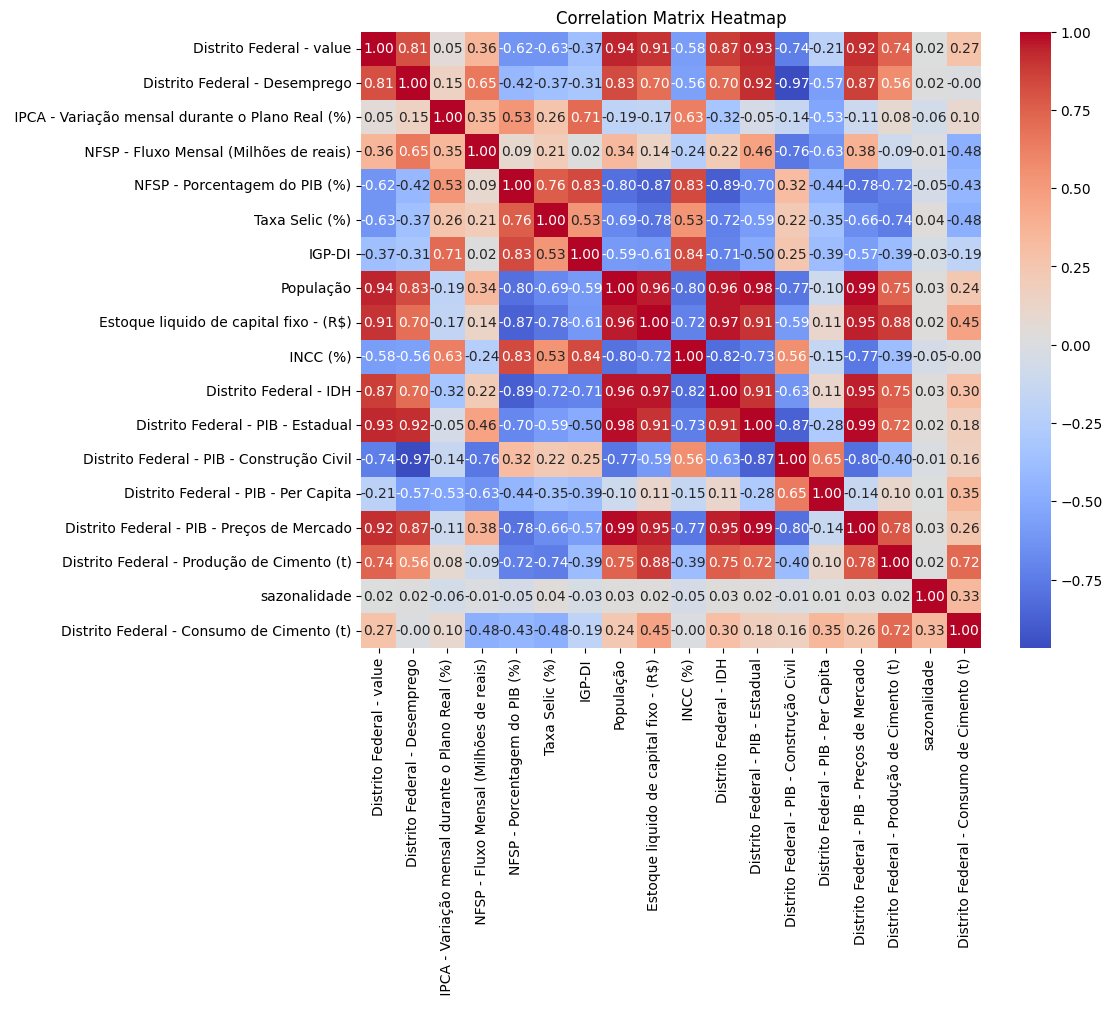

In [36]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [37]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [38]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,Distrito Federal - value,2.679424e+04
1,Distrito Federal - Desemprego,2.584882e+03
2,IPCA - Variação mensal durante o Plano Real (%),2.367846e+03
3,NFSP - Fluxo Mensal (Milhões de reais),4.004763e+02
4,NFSP - Porcentagem do PIB (%),6.423066e+02
5,Taxa Selic (%),5.592043e+01
6,IGP-DI,3.215953e+02
7,População,1.304182e+07
8,Estoque liquido de capital fixo - (R$),5.171666e+06
9,INCC (%),1.833994e+03


In [39]:
# data =data.drop(['Air Temperature - Dry Bulb (°C)',
#                  'Precipitation (mm/day)',
#                  'Global Radiation - Daylight (Kj/m²)', 
#                  'Air Relative Humidity (%)'], axis=1)
data = remove_high_vif_columns(safe_data, 1000000)
data

Num columns removed: 4


,Distrito Federal - value,Distrito Federal - Desemprego,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,Estoque liquido de capital fixo - (R$),INCC (%),Distrito Federal - PIB - Estadual,Distrito Federal - PIB - Construção Civil,Distrito Federal - Produção de Cimento (t),sazonalidade
0,0.254227,8.293882,0.724032,-5331.049150,11.520143,1.639718,1.036534,7.330309e+06,0.969649,1.184017e+08,3.570616e+06,156.625720,70.194429
1,0.252655,8.287887,0.690297,-5318.079644,11.189862,1.378899,0.993449,7.335910e+06,0.950783,1.185511e+08,3.573184e+06,157.678528,67.700143
2,0.250972,8.281892,0.669681,-5436.417870,10.820792,1.924317,0.973020,7.341511e+06,0.938332,1.187006e+08,3.575752e+06,159.190268,74.741036
3,0.249179,8.275896,0.660494,-5707.015274,10.417840,1.331174,0.940489,7.347112e+06,0.926401,1.188500e+08,3.578320e+06,160.688376,72.748071
4,0.247070,8.269901,0.648337,-5599.317941,9.959690,1.736072,0.917493,7.352713e+06,0.951683,1.189994e+08,3.580889e+06,162.847410,79.418643
...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.334779,12.046727,0.366904,-5783.316460,2.206994,0.545067,0.471521,7.783063e+06,0.378150,1.414907e+08,3.440246e+06,227.223673,89.086714
176,0.335574,12.041170,0.358935,-6001.730740,2.215328,0.782910,0.476827,7.780841e+06,0.377666,1.414558e+08,3.442176e+06,225.662180,85.934714
177,0.336250,12.035612,0.354313,-6454.887704,2.232466,0.909682,0.475427,7.778619e+06,0.377838,1.414208e+08,3.444106e+06,224.312608,85.735214
178,0.337539,12.030054,0.352728,-6243.191421,2.263185,1.050614,0.491301,7.776397e+06,0.370057,1.413859e+08,3.446035e+06,222.710066,77.502429


In [40]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Distrito Federal - Desemprego,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,Estoque liquido de capital fixo - (R$),INCC (%),Distrito Federal - PIB - Estadual,Distrito Federal - PIB - Construção Civil,Distrito Federal - Produção de Cimento (t)
0,-0.764190,2.802383,0.604311,4.268118,2.039314,3.921218,-2.299937,3.214079,-1.638679,0.325878,-1.923354
1,-0.767512,2.402642,0.609431,4.096014,1.195209,3.582946,-2.263992,3.051841,-1.619603,0.361202,-1.900451
2,-0.770833,2.158351,0.562720,3.903698,2.960381,3.422548,-2.228047,2.944772,-1.600527,0.396525,-1.867563
3,-0.774155,2.049492,0.455907,3.693727,1.040752,3.167136,-2.192102,2.842174,-1.581451,0.431849,-1.834972
4,-0.777476,1.905441,0.498418,3.454992,2.351150,2.986591,-2.156157,3.059587,-1.562375,0.467172,-1.788003
...,...,...,...,...,...,...,...,...,...,...,...
175,1.314958,-1.429358,0.425789,-0.584804,-1.503380,-0.514871,0.605679,-1.872446,1.309231,-1.467255,-0.387516
176,1.311879,-1.523783,0.339575,-0.580461,-0.733634,-0.473208,0.591420,-1.876611,1.304773,-1.440710,-0.421486
177,1.308800,-1.578548,0.160702,-0.571531,-0.323353,-0.484199,0.577161,-1.875135,1.300315,-1.414165,-0.450846
178,1.305721,-1.597335,0.244264,-0.555524,0.132757,-0.359568,0.562902,-1.942040,1.295857,-1.387621,-0.485708


In [41]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Distrito Federal - Desemprego,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,Estoque liquido de capital fixo - (R$),INCC (%),Distrito Federal - PIB - Estadual,Distrito Federal - PIB - Construção Civil,Distrito Federal - Produção de Cimento (t)
0,-0.764190,2.802383,0.604311,4.268118,2.039314,3.921218,-2.299937,3.214079,-1.638679,0.325878,-1.923354
1,-0.767512,2.402642,0.609431,4.096014,1.195209,3.582946,-2.263992,3.051841,-1.619603,0.361202,-1.900451
2,-0.770833,2.158351,0.562720,3.903698,2.960381,3.422548,-2.228047,2.944772,-1.600527,0.396525,-1.867563
3,-0.774155,2.049492,0.455907,3.693727,1.040752,3.167136,-2.192102,2.842174,-1.581451,0.431849,-1.834972
4,-0.777476,1.905441,0.498418,3.454992,2.351150,2.986591,-2.156157,3.059587,-1.562375,0.467172,-1.788003
...,...,...,...,...,...,...,...,...,...,...,...
163,1.371868,-0.960452,1.465326,-0.676734,0.472779,-1.087000,0.759879,-1.491033,1.334471,-1.628027,-0.137790
164,1.364797,-1.007966,1.351131,-0.668750,0.302784,-0.904679,0.749001,-1.525186,1.335664,-1.633035,-0.150045
165,1.357725,-0.976556,1.143146,-0.657609,0.339539,-0.900134,0.738124,-1.546744,1.336857,-1.638043,-0.166182
166,1.350654,-1.146834,1.542609,-0.647588,0.472795,-1.136836,0.727246,-1.586381,1.338051,-1.643051,-0.194921


In [42]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      62.294
1      55.247
2      65.908
3      67.387
4      68.730
        ...  
163    58.854
164    53.940
165    51.514
166    42.635
167    40.371
Name: Distrito Federal - Consumo de Cimento (t), Length: 168, dtype: float64

In [43]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [44]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(132, 36, 11)

In [45]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Distrito Federal - Desemprego,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,Estoque liquido de capital fixo - (R$),INCC (%),Distrito Federal - PIB - Estadual,Distrito Federal - PIB - Construção Civil,Distrito Federal - Produção de Cimento (t)
132,1.178149,1.530065,0.817451,-0.366715,-0.530011,0.174628,0.965586,-0.066954,1.025607,-0.965888,1.373328
133,1.191719,1.649361,1.130195,-0.350285,-0.532694,0.240832,0.962419,-0.130652,1.041004,-1.010214,1.336965
134,1.205289,1.622916,1.160498,-0.335122,-0.186421,0.176857,0.959252,-0.079602,1.056402,-1.054540,1.291634
135,1.218858,1.581460,1.131990,-0.321950,-0.719664,-0.005233,0.956085,-0.034473,1.071799,-1.098866,1.244049
136,1.232428,1.638292,1.384387,-0.302995,-0.798520,0.097576,0.952918,-0.177535,1.087196,-1.143191,1.194731
137,1.245997,1.643773,1.375487,-0.290554,-0.612129,0.431487,0.949751,-0.208868,1.102594,-1.187517,1.143680
138,1.259567,1.704584,1.438928,-0.281926,-0.476740,0.482414,0.946584,-0.245300,1.117991,-1.231843,1.091101
139,1.273137,1.841703,1.569590,-0.275931,-0.211736,0.657043,0.943417,-0.333490,1.133389,-1.276169,1.037140
140,1.286706,1.837218,1.584058,-0.271466,-0.484608,0.678386,0.940250,-0.296846,1.148786,-1.320494,0.981966
141,1.300276,1.797860,1.166380,-0.273241,-0.183907,0.727143,0.937082,-0.292462,1.164184,-1.364820,0.925910


In [46]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 11)

In [47]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [48]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(36, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.LSTM(72, activation='tanh', 
                             kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.07,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [49]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [50]:
winner_seed = get_a_good_seed(reshaped_train, reshaped_target, reshaped_test, reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[563041883, 1159815596, 679315838, 3511563736, 3239578503, 2493863043, 2658931218, 505283964, 3824748259, 764013745]


Step: 0 ___________________________________________
val_loss: 47.056087493896484
winner_seed: 563041883


Step: 1 ___________________________________________
val_loss: 45.386695861816406
winner_seed: 1159815596


Step: 2 ___________________________________________
val_loss: 45.66117477416992


Step: 3 ___________________________________________
val_loss: 36.20872497558594
winner_seed: 3511563736


Step: 4 ___________________________________________
val_loss: 51.64354705810547


Step: 5 ___________________________________________
val_loss: 48.199607849121094


Step: 6 ___________________________________________
val_loss: 46.98215866088867


Step: 7 ___________________________________________
val_loss: 47.61090087890625


Step: 8 ___________________________________________
val_loss: 62.28923797607422


Step: 9 ___________________________________________
val_loss: 50.8613

In [51]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)
# 3105829098

Epoch 1/10000
4/4 [==============================] - 2s 287ms/step - loss: 5585.2617 - val_loss: 342.9094
Epoch 2/10000
4/4 [==============================] - 0s 10ms/step - loss: 558.2236 - val_loss: 1012.4867
Epoch 3/10000
4/4 [==============================] - 0s 10ms/step - loss: 455.3485 - val_loss: 961.9491
Epoch 4/10000
4/4 [==============================] - 0s 11ms/step - loss: 358.2874 - val_loss: 3214.4321
Epoch 5/10000
4/4 [==============================] - 0s 10ms/step - loss: 831.6729 - val_loss: 1118.0087
Epoch 6/10000
4/4 [==============================] - 0s 10ms/step - loss: 414.8571 - val_loss: 575.1625
Epoch 7/10000
4/4 [==============================] - 0s 10ms/step - loss: 315.5441 - val_loss: 183.0407
Epoch 8/10000
4/4 [==============================] - 0s 10ms/step - loss: 221.2381 - val_loss: 199.6606
Epoch 9/10000
4/4 [==============================] - 0s 10ms/step - loss: 191.6187 - val_loss: 83.9108
Epoch 10/10000
4/4 [==============================] - 0s 11m

4/4 [==============================] - 0s 10ms/step - loss: 80.7102 - val_loss: 51.8931
Epoch 81/10000
4/4 [==============================] - 0s 10ms/step - loss: 75.8105 - val_loss: 73.2788
Epoch 82/10000
4/4 [==============================] - 0s 11ms/step - loss: 73.6774 - val_loss: 60.3618
Epoch 83/10000
4/4 [==============================] - 0s 10ms/step - loss: 60.9229 - val_loss: 55.6078
Epoch 84/10000
4/4 [==============================] - 0s 10ms/step - loss: 83.5764 - val_loss: 48.2334
Epoch 85/10000
4/4 [==============================] - 0s 11ms/step - loss: 104.1785 - val_loss: 64.4841
Epoch 86/10000
4/4 [==============================] - 0s 9ms/step - loss: 68.3122 - val_loss: 47.5373
Epoch 87/10000
4/4 [==============================] - 0s 10ms/step - loss: 74.3646 - val_loss: 49.3778
Epoch 88/10000
4/4 [==============================] - 0s 10ms/step - loss: 71.1202 - val_loss: 55.1073
Epoch 89/10000
4/4 [==============================] - 0s 10ms/step - loss: 63.1156 - val

4/4 [==============================] - 0s 11ms/step - loss: 29.6194 - val_loss: 56.5844
Epoch 160/10000
4/4 [==============================] - 0s 11ms/step - loss: 28.6090 - val_loss: 65.4558
Epoch 161/10000
4/4 [==============================] - 0s 12ms/step - loss: 34.8598 - val_loss: 54.1224
Epoch 162/10000
4/4 [==============================] - 0s 11ms/step - loss: 29.8498 - val_loss: 52.2781
Epoch 163/10000
4/4 [==============================] - 0s 12ms/step - loss: 25.1432 - val_loss: 62.3197
Epoch 164/10000
4/4 [==============================] - 0s 11ms/step - loss: 24.1957 - val_loss: 58.6972
Epoch 165/10000
4/4 [==============================] - 0s 11ms/step - loss: 25.4243 - val_loss: 62.7551
Epoch 166/10000
4/4 [==============================] - 0s 11ms/step - loss: 23.8870 - val_loss: 75.0787
Epoch 167/10000
4/4 [==============================] - 0s 12ms/step - loss: 29.2792 - val_loss: 62.8150
Epoch 168/10000
4/4 [==============================] - 0s 11ms/step - loss: 29.2

Epoch 238/10000
4/4 [==============================] - 0s 11ms/step - loss: 25.9440 - val_loss: 72.5869
Epoch 239/10000
4/4 [==============================] - 0s 12ms/step - loss: 28.5078 - val_loss: 58.1179
Epoch 240/10000
4/4 [==============================] - 0s 11ms/step - loss: 25.9913 - val_loss: 53.0330
Epoch 241/10000
4/4 [==============================] - 0s 11ms/step - loss: 22.8563 - val_loss: 52.7286
Epoch 242/10000
4/4 [==============================] - 0s 10ms/step - loss: 23.1303 - val_loss: 59.5654
Epoch 243/10000
4/4 [==============================] - 0s 11ms/step - loss: 26.7215 - val_loss: 58.7462
Epoch 244/10000
4/4 [==============================] - 0s 10ms/step - loss: 23.2133 - val_loss: 52.5625
Epoch 245/10000
4/4 [==============================] - 0s 11ms/step - loss: 24.1422 - val_loss: 53.7300
Epoch 246/10000
4/4 [==============================] - 0s 11ms/step - loss: 24.8135 - val_loss: 52.8949
Epoch 247/10000
4/4 [==============================] - 0s 11ms/s

Epoch 317/10000
4/4 [==============================] - 0s 11ms/step - loss: 20.3745 - val_loss: 50.6632
Epoch 318/10000
4/4 [==============================] - 0s 13ms/step - loss: 20.0817 - val_loss: 50.8321
Epoch 319/10000
4/4 [==============================] - 0s 11ms/step - loss: 23.2324 - val_loss: 50.6277
Epoch 320/10000
4/4 [==============================] - 0s 11ms/step - loss: 23.7463 - val_loss: 50.8222
Epoch 321/10000
4/4 [==============================] - 0s 12ms/step - loss: 19.6086 - val_loss: 50.0519
Epoch 322/10000
4/4 [==============================] - 0s 11ms/step - loss: 20.9240 - val_loss: 52.9732
Epoch 323/10000
4/4 [==============================] - 0s 11ms/step - loss: 20.0326 - val_loss: 50.1569
Epoch 324/10000
4/4 [==============================] - 0s 11ms/step - loss: 20.6746 - val_loss: 53.6517
Epoch 325/10000
4/4 [==============================] - 0s 10ms/step - loss: 19.6532 - val_loss: 50.2160
Epoch 326/10000
4/4 [==============================] - 0s 10ms/s

Epoch 396/10000
4/4 [==============================] - 0s 11ms/step - loss: 18.2666 - val_loss: 51.0138
Epoch 397/10000
4/4 [==============================] - 0s 11ms/step - loss: 17.5565 - val_loss: 53.2402
Epoch 398/10000
4/4 [==============================] - 0s 11ms/step - loss: 29.6092 - val_loss: 57.5351
Epoch 399/10000
4/4 [==============================] - 0s 11ms/step - loss: 86.5327 - val_loss: 51.0184
Epoch 400/10000
4/4 [==============================] - 0s 11ms/step - loss: 95.6326 - val_loss: 59.1309
Epoch 401/10000
4/4 [==============================] - 0s 11ms/step - loss: 68.9988 - val_loss: 52.3671
Epoch 402/10000
4/4 [==============================] - 0s 11ms/step - loss: 60.2408 - val_loss: 52.4773
Epoch 403/10000
4/4 [==============================] - 0s 11ms/step - loss: 49.7738 - val_loss: 51.9907
Epoch 404/10000
4/4 [==============================] - 0s 11ms/step - loss: 53.3065 - val_loss: 49.1254
Epoch 405/10000
4/4 [==============================] - 0s 11ms/s

Epoch 475/10000
4/4 [==============================] - 0s 11ms/step - loss: 17.4695 - val_loss: 51.2768
Epoch 476/10000
4/4 [==============================] - 0s 11ms/step - loss: 15.3604 - val_loss: 52.7185
Epoch 477/10000
4/4 [==============================] - 0s 11ms/step - loss: 16.9740 - val_loss: 60.3540
Epoch 478/10000
4/4 [==============================] - 0s 11ms/step - loss: 18.5723 - val_loss: 59.9269
Epoch 479/10000
4/4 [==============================] - 0s 12ms/step - loss: 17.5648 - val_loss: 59.1964
Epoch 480/10000
4/4 [==============================] - 0s 10ms/step - loss: 15.2496 - val_loss: 53.0637
Epoch 481/10000
4/4 [==============================] - 0s 11ms/step - loss: 15.7321 - val_loss: 54.9845
Epoch 482/10000
4/4 [==============================] - 0s 11ms/step - loss: 17.6736 - val_loss: 77.4020
Epoch 483/10000
4/4 [==============================] - 0s 10ms/step - loss: 16.0278 - val_loss: 70.9212
Epoch 484/10000
4/4 [==============================] - 0s 11ms/s

Epoch 554/10000
4/4 [==============================] - 0s 11ms/step - loss: 12.2565 - val_loss: 71.7294
Epoch 555/10000
4/4 [==============================] - 0s 10ms/step - loss: 13.0057 - val_loss: 56.6414
Epoch 556/10000
4/4 [==============================] - 0s 11ms/step - loss: 14.7045 - val_loss: 70.8092
Epoch 557/10000
4/4 [==============================] - 0s 12ms/step - loss: 15.6930 - val_loss: 71.3859
Epoch 558/10000
4/4 [==============================] - 0s 11ms/step - loss: 13.8895 - val_loss: 63.3043
Epoch 559/10000
4/4 [==============================] - 0s 11ms/step - loss: 15.5577 - val_loss: 58.5570
Epoch 560/10000
4/4 [==============================] - 0s 11ms/step - loss: 13.6633 - val_loss: 69.2523
Epoch 561/10000
4/4 [==============================] - 0s 11ms/step - loss: 14.5365 - val_loss: 71.9013
Epoch 562/10000
4/4 [==============================] - 0s 11ms/step - loss: 14.9030 - val_loss: 78.7935
Epoch 563/10000
4/4 [==============================] - 0s 11ms/s

4/4 [==============================] - 0s 9ms/step - loss: 11.7392 - val_loss: 50.9985
Epoch 634/10000
4/4 [==============================] - 0s 9ms/step - loss: 13.5063 - val_loss: 67.5239
Epoch 635/10000
4/4 [==============================] - 0s 9ms/step - loss: 9.6800 - val_loss: 58.6342
Epoch 636/10000
4/4 [==============================] - 0s 9ms/step - loss: 11.7998 - val_loss: 58.6930
Epoch 637/10000
4/4 [==============================] - 0s 9ms/step - loss: 10.3035 - val_loss: 64.9815
Epoch 638/10000
4/4 [==============================] - 0s 10ms/step - loss: 10.3717 - val_loss: 57.2168
Epoch 639/10000
4/4 [==============================] - 0s 10ms/step - loss: 10.7909 - val_loss: 57.4195
Epoch 640/10000
4/4 [==============================] - 0s 9ms/step - loss: 11.2161 - val_loss: 63.5325
Epoch 641/10000
4/4 [==============================] - 0s 9ms/step - loss: 12.3055 - val_loss: 59.7501
Epoch 642/10000
4/4 [==============================] - 0s 9ms/step - loss: 10.7143 - val

4/4 [==============================] - 0s 8ms/step - loss: 8.5572 - val_loss: 54.1576
Epoch 714/10000
4/4 [==============================] - 0s 8ms/step - loss: 6.4741 - val_loss: 59.2323
Epoch 715/10000
4/4 [==============================] - 0s 8ms/step - loss: 10.3558 - val_loss: 58.6068
Epoch 716/10000
4/4 [==============================] - 0s 8ms/step - loss: 8.8698 - val_loss: 49.4676
Epoch 717/10000
4/4 [==============================] - 0s 8ms/step - loss: 8.8778 - val_loss: 54.9518
Epoch 718/10000
4/4 [==============================] - 0s 8ms/step - loss: 9.7389 - val_loss: 59.4315
Epoch 719/10000
4/4 [==============================] - 0s 8ms/step - loss: 7.7884 - val_loss: 60.3317
Epoch 720/10000
4/4 [==============================] - 0s 8ms/step - loss: 8.4299 - val_loss: 57.7980
Epoch 721/10000
4/4 [==============================] - 0s 8ms/step - loss: 8.8232 - val_loss: 62.1752
Epoch 722/10000
4/4 [==============================] - 0s 8ms/step - loss: 9.7993 - val_loss: 61.

Epoch 793/10000
4/4 [==============================] - 0s 9ms/step - loss: 11.7565 - val_loss: 51.9116
Epoch 794/10000
4/4 [==============================] - 0s 8ms/step - loss: 16.8003 - val_loss: 50.4320
Epoch 795/10000
4/4 [==============================] - 0s 8ms/step - loss: 11.1648 - val_loss: 49.0614
Epoch 796/10000
4/4 [==============================] - 0s 9ms/step - loss: 11.2169 - val_loss: 48.8083
Epoch 797/10000
4/4 [==============================] - 0s 9ms/step - loss: 8.0778 - val_loss: 49.7725
Epoch 798/10000
4/4 [==============================] - 0s 10ms/step - loss: 9.8683 - val_loss: 48.6434
Epoch 799/10000
4/4 [==============================] - 0s 9ms/step - loss: 9.7644 - val_loss: 50.4595
Epoch 800/10000
4/4 [==============================] - 0s 9ms/step - loss: 10.2067 - val_loss: 49.6229
Epoch 801/10000
4/4 [==============================] - 0s 10ms/step - loss: 10.0215 - val_loss: 48.6272
Epoch 802/10000
4/4 [==============================] - 0s 9ms/step - loss:

4/4 [==============================] - 0s 10ms/step - loss: 8.6098 - val_loss: 48.8393
Epoch 874/10000
4/4 [==============================] - 0s 9ms/step - loss: 9.2011 - val_loss: 52.7053
Epoch 875/10000
4/4 [==============================] - 0s 9ms/step - loss: 9.7965 - val_loss: 50.7278
Epoch 876/10000
4/4 [==============================] - 0s 8ms/step - loss: 6.6759 - val_loss: 48.8110
Epoch 877/10000
4/4 [==============================] - 0s 9ms/step - loss: 9.6522 - val_loss: 48.0284
Epoch 878/10000
4/4 [==============================] - 0s 9ms/step - loss: 11.5603 - val_loss: 48.9432
Epoch 879/10000
4/4 [==============================] - 0s 9ms/step - loss: 12.0566 - val_loss: 49.0017
Epoch 880/10000
4/4 [==============================] - 0s 9ms/step - loss: 7.4818 - val_loss: 49.6872
Epoch 881/10000
4/4 [==============================] - 0s 8ms/step - loss: 8.0759 - val_loss: 51.8229
Epoch 882/10000
4/4 [==============================] - 0s 8ms/step - loss: 7.7410 - val_loss: 4

4/4 [==============================] - 0s 9ms/step - loss: 7.2462 - val_loss: 49.0127
Epoch 954/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.6843 - val_loss: 49.2411
Epoch 955/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.8753 - val_loss: 48.8058
Epoch 956/10000
4/4 [==============================] - 0s 8ms/step - loss: 6.9821 - val_loss: 48.4130
Epoch 957/10000
4/4 [==============================] - 0s 8ms/step - loss: 6.3098 - val_loss: 48.0677
Epoch 958/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.4965 - val_loss: 50.1723
Epoch 959/10000
4/4 [==============================] - 0s 9ms/step - loss: 9.0292 - val_loss: 49.1902
Epoch 960/10000
4/4 [==============================] - 0s 9ms/step - loss: 7.3162 - val_loss: 48.4479
Epoch 961/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.0281 - val_loss: 48.4812
Epoch 962/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.7821 - val_loss: 49.1

4/4 [==============================] - 0s 10ms/step - loss: 6.4982 - val_loss: 48.5857
Epoch 1033/10000
4/4 [==============================] - 0s 10ms/step - loss: 5.2986 - val_loss: 49.1353
Epoch 1034/10000
4/4 [==============================] - 0s 10ms/step - loss: 6.7132 - val_loss: 49.0300
Epoch 1035/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.1753 - val_loss: 48.4527
Epoch 1036/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.6625 - val_loss: 48.4219
Epoch 1037/10000
4/4 [==============================] - 0s 11ms/step - loss: 6.4102 - val_loss: 48.6361
Epoch 1038/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.0673 - val_loss: 47.9695
Epoch 1039/10000
4/4 [==============================] - 0s 10ms/step - loss: 6.0468 - val_loss: 48.8740
Epoch 1040/10000
4/4 [==============================] - 0s 10ms/step - loss: 6.3230 - val_loss: 49.1420
Epoch 1041/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.0833 -

4/4 [==============================] - 0s 9ms/step - loss: 6.1553 - val_loss: 49.1451
Epoch 1112/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.8857 - val_loss: 50.3311
Epoch 1113/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.3001 - val_loss: 50.9348
Epoch 1114/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.6968 - val_loss: 51.4860
Epoch 1115/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.5797 - val_loss: 50.7496
Epoch 1116/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.5113 - val_loss: 50.5664
Epoch 1117/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.9421 - val_loss: 49.1160
Epoch 1118/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.6765 - val_loss: 50.0481
Epoch 1119/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.6147 - val_loss: 50.0435
Epoch 1120/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.8250 - val_l

4/4 [==============================] - 0s 10ms/step - loss: 5.3692 - val_loss: 51.5928
Epoch 1191/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.0945 - val_loss: 51.7136
Epoch 1192/10000
4/4 [==============================] - 0s 10ms/step - loss: 5.0782 - val_loss: 49.7311
Epoch 1193/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.8400 - val_loss: 48.9950
Epoch 1194/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.9352 - val_loss: 49.4899
Epoch 1195/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.8275 - val_loss: 49.9968
Epoch 1196/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.4007 - val_loss: 51.7236
Epoch 1197/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.7961 - val_loss: 51.2320
Epoch 1198/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.7969 - val_loss: 51.3565
Epoch 1199/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.6441 - v

4/4 [==============================] - 0s 11ms/step - loss: 122.2906 - val_loss: 36.2087
Epoch 1270/10000
4/4 [==============================] - 0s 10ms/step - loss: 111.6741 - val_loss: 59.2965
Epoch 1271/10000
4/4 [==============================] - 0s 10ms/step - loss: 81.8992 - val_loss: 71.4417
Epoch 1272/10000
4/4 [==============================] - 0s 10ms/step - loss: 77.8303 - val_loss: 43.8499
Epoch 1273/10000
4/4 [==============================] - 0s 10ms/step - loss: 79.3493 - val_loss: 52.5645
Epoch 1274/10000
4/4 [==============================] - 0s 10ms/step - loss: 65.9505 - val_loss: 62.8789
Epoch 1275/10000
4/4 [==============================] - 0s 10ms/step - loss: 61.7149 - val_loss: 58.9778
Epoch 1276/10000
4/4 [==============================] - 0s 11ms/step - loss: 58.9614 - val_loss: 55.7469
Epoch 1277/10000
4/4 [==============================] - 0s 10ms/step - loss: 68.0845 - val_loss: 82.1659
Epoch 1278/10000
4/4 [==============================] - 0s 9ms/step - 

4/4 [==============================] - 0s 10ms/step - loss: 12.9681 - val_loss: 59.5613
Epoch 1348/10000
4/4 [==============================] - 0s 10ms/step - loss: 14.2165 - val_loss: 63.8752
Epoch 1349/10000
4/4 [==============================] - 0s 10ms/step - loss: 11.3266 - val_loss: 63.5717
Epoch 1350/10000
4/4 [==============================] - 0s 9ms/step - loss: 11.0321 - val_loss: 60.2001
Epoch 1351/10000
4/4 [==============================] - 0s 10ms/step - loss: 14.6495 - val_loss: 63.8609
Epoch 1352/10000
4/4 [==============================] - 0s 9ms/step - loss: 34.3915 - val_loss: 51.0150
Epoch 1353/10000
4/4 [==============================] - 0s 9ms/step - loss: 16.7249 - val_loss: 56.3428
Epoch 1354/10000
4/4 [==============================] - 0s 9ms/step - loss: 13.0450 - val_loss: 52.3307
Epoch 1355/10000
4/4 [==============================] - 0s 10ms/step - loss: 10.4768 - val_loss: 60.2805
Epoch 1356/10000
4/4 [==============================] - 0s 10ms/step - loss:

4/4 [==============================] - 0s 9ms/step - loss: 7.4863 - val_loss: 50.2481
Epoch 1427/10000
4/4 [==============================] - 0s 8ms/step - loss: 8.2852 - val_loss: 46.8823
Epoch 1428/10000
4/4 [==============================] - 0s 8ms/step - loss: 7.0666 - val_loss: 47.2448
Epoch 1429/10000
4/4 [==============================] - 0s 8ms/step - loss: 7.9129 - val_loss: 54.6108
Epoch 1430/10000
4/4 [==============================] - 0s 9ms/step - loss: 7.3917 - val_loss: 47.6630
Epoch 1431/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.7371 - val_loss: 46.8010
Epoch 1432/10000
4/4 [==============================] - 0s 9ms/step - loss: 7.3511 - val_loss: 54.3208
Epoch 1433/10000
4/4 [==============================] - 0s 9ms/step - loss: 7.2933 - val_loss: 56.1166
Epoch 1434/10000
4/4 [==============================] - 0s 8ms/step - loss: 6.2864 - val_loss: 50.8272
Epoch 1435/10000
4/4 [==============================] - 0s 9ms/step - loss: 8.6540 - val_l

4/4 [==============================] - 0s 10ms/step - loss: 5.8919 - val_loss: 49.7167
Epoch 1506/10000
4/4 [==============================] - 0s 10ms/step - loss: 6.4655 - val_loss: 51.7545
Epoch 1507/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.9880 - val_loss: 52.2604
Epoch 1508/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.3664 - val_loss: 52.9616
Epoch 1509/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.7104 - val_loss: 55.2770
Epoch 1510/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.9162 - val_loss: 50.9804
Epoch 1511/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.1992 - val_loss: 51.5907
Epoch 1512/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.5335 - val_loss: 48.9940
Epoch 1513/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.2819 - val_loss: 46.7222
Epoch 1514/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.6127 - val

4/4 [==============================] - 0s 9ms/step - loss: 5.7035 - val_loss: 54.7138
Epoch 1585/10000
4/4 [==============================] - 0s 8ms/step - loss: 6.2244 - val_loss: 53.4040
Epoch 1586/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.4466 - val_loss: 55.4203
Epoch 1587/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.4312 - val_loss: 55.0258
Epoch 1588/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.7902 - val_loss: 55.5414
Epoch 1589/10000
4/4 [==============================] - 0s 10ms/step - loss: 6.9218 - val_loss: 57.6778
Epoch 1590/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.5724 - val_loss: 55.8582
Epoch 1591/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.0915 - val_loss: 53.3655
Epoch 1592/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.1126 - val_loss: 52.8064
Epoch 1593/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.9666 - val_

4/4 [==============================] - 0s 11ms/step - loss: 5.1831 - val_loss: 55.2841
Epoch 1664/10000
4/4 [==============================] - 0s 10ms/step - loss: 5.4075 - val_loss: 55.5289
Epoch 1665/10000
4/4 [==============================] - 0s 10ms/step - loss: 6.1782 - val_loss: 54.5367
Epoch 1666/10000
4/4 [==============================] - 0s 10ms/step - loss: 5.0636 - val_loss: 54.5607
Epoch 1667/10000
4/4 [==============================] - 0s 11ms/step - loss: 5.5443 - val_loss: 54.4129
Epoch 1668/10000
4/4 [==============================] - 0s 12ms/step - loss: 5.0831 - val_loss: 55.0264
Epoch 1669/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.9018 - val_loss: 55.0195
Epoch 1670/10000
4/4 [==============================] - 0s 10ms/step - loss: 5.1236 - val_loss: 53.3310
Epoch 1671/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.7966 - val_loss: 54.3452
Epoch 1672/10000
4/4 [==============================] - 0s 11ms/step - loss: 5.46

4/4 [==============================] - 0s 9ms/step - loss: 17.1724 - val_loss: 51.4055
Epoch 1743/10000
4/4 [==============================] - 0s 9ms/step - loss: 15.4893 - val_loss: 52.2718
Epoch 1744/10000
4/4 [==============================] - 0s 9ms/step - loss: 12.8146 - val_loss: 48.6746
Epoch 1745/10000
4/4 [==============================] - 0s 9ms/step - loss: 17.0641 - val_loss: 50.3660
Epoch 1746/10000
4/4 [==============================] - 0s 9ms/step - loss: 16.0642 - val_loss: 49.6685
Epoch 1747/10000
4/4 [==============================] - 0s 9ms/step - loss: 22.5367 - val_loss: 45.2376
Epoch 1748/10000
4/4 [==============================] - 0s 9ms/step - loss: 19.2899 - val_loss: 49.1233
Epoch 1749/10000
4/4 [==============================] - 0s 9ms/step - loss: 13.8487 - val_loss: 50.3638
Epoch 1750/10000
4/4 [==============================] - 0s 9ms/step - loss: 14.7945 - val_loss: 44.6532
Epoch 1751/10000
4/4 [==============================] - 0s 9ms/step - loss: 12.89

In [52]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [53]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 15ms/step


,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,45.292465,47.103382,51.659069,52.185165,52.503571,55.697678,51.722771,53.547409,64.115906,64.761971,61.361176,56.817497
Target,48.99,44.726,44.491,43.901,55.019,50.942,63.992,64.127,60.822,65.182,51.282,43.554
Error,3.697536,2.37738,7.168068,8.284164,2.51543,4.755676,12.26923,10.57959,3.293907,0.420029,10.079174,13.263496


In [54]:
display(mae)
display(mape)

6.55864

0.12799178

In [55]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [56]:
errors, mae, mape = year_mae_mape_calculator(trained_model, 
                                             reshaped_test, 
                                             reshaped_test_target, 
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 15ms/step
Ano-11: |Prediction[[656.76807]] - Target[637.028]| =  Error: [[19.740051]]; MAPE:[[0.03098773]]


[array([[19.740051]], dtype=float32)]

19.740051

0.030987728